# Milestone 1

This milestone delivers an initial working MVP for ransomware attack detection using Deep Q-Network (DQN) reinforcement learning applied to the UGRansome dataset. The project involves loading and preprocessing network traffic data, building a custom reinforcement learning environment where an agent learns to classify benign versus ransomware traffic flows, and training a DQN model with epsilon-greedy exploration, experience replay, and target network updates. The model is evaluated on a random train/test split to measure detection accuracy, demonstrating the feasibility of applying deep reinforcement learning techniques to cybersecurity threat identification without relying on prior knowledge of attack signatures.

# Import Libraries



In [1]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Data Preprocessing 

In [2]:


# 1. Load the UGRansome dataset
data = pd.read_csv('/kaggle/input/ugransome-dataset/final(2).csv')
# Assign proper column names (if not already present)
data.columns = ["Time", "Protocol", "Flag", "Family", "Clusters", "SeedAddress",
               "ExpAddress", "BTC", "USD", "Netflow_Bytes", "IPaddress",
               "Threats", "Port", "Prediction"]

# Handle missing values if any (drop for simplicity)
if data.isnull().values.any():
    data = data.dropna()

# 2. Map the Prediction column to a binary Label (0 = benign/normal, 1 = ransomware/anomaly)
data['Label'] = data['Prediction'].map({'S': 0, 'A': 1, 'SS': 1})
# Drop the original Prediction column and identifier fields we won't use as features
data = data.drop(columns=['Prediction', 'SeedAddress', 'ExpAddress', 'IPaddress'])

# 3. Encode categorical features to numeric
label_encoder = LabelEncoder()
for col in ['Protocol', 'Flag', 'Family', 'Threats']:
    # If the column is not already numeric, apply label encoding
    if data[col].dtype == object or str(data[col].dtype).startswith('category'):
        data[col] = label_encoder.fit_transform(data[col].astype(str))

# EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149043 entries, 0 to 149042
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Time           149043 non-null  int64
 1   Protocol       149043 non-null  int64
 2   Flag           149043 non-null  int64
 3   Family         149043 non-null  int64
 4   Clusters       149043 non-null  int64
 5   BTC            149043 non-null  int64
 6   USD            149043 non-null  int64
 7   Netflow_Bytes  149043 non-null  int64
 8   Threats        149043 non-null  int64
 9   Port           149043 non-null  int64
 10  Label          149043 non-null  int64
dtypes: int64(11)
memory usage: 12.5 MB
None
                Time       Protocol           Flag         Family  \
count  149043.000000  149043.000000  149043.000000  149043.000000   
mean       21.466979       1.039318       3.595358       9.349094   
std        15.883598       0.735827       2.519626       4.843160   
min      

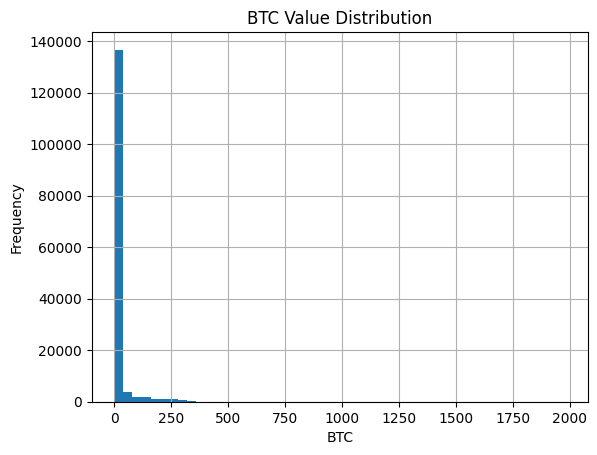

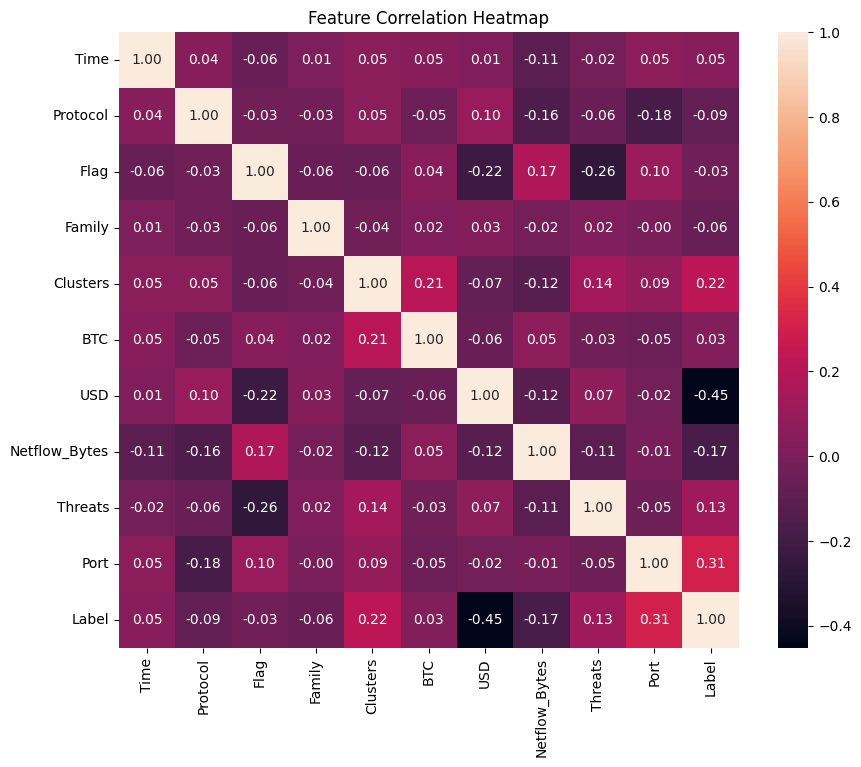

In [3]:
#  Check basic information about dataset
print(data.info())

#  View basic statistical summaries (mean, std, min, max, etc.)
print(data.describe())

# 3. Check class balance (important for ML)
print(data['Label'].value_counts())

# Visualize distributions of some features
import matplotlib.pyplot as plt

data['BTC'].hist(bins=50)
plt.title('BTC Value Distribution')
plt.xlabel('BTC')
plt.ylabel('Frequency')
plt.show()

# 5. Check correlations between numeric features
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


# Data Normalization and Dataset Splitting

In [4]:

# 4. Feature scaling (Min-Max normalization for numeric fields)
scaler = MinMaxScaler()
# Identify feature columns (all columns except the Label)
feature_cols = [col for col in data.columns if col != 'Label']
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# 5. Split into training and testing sets
X = data[feature_cols].values.astype(np.float32)
y = data['Label'].values.astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the Ransomware Environment

In [5]:
# 6. Define thec learning environment
class RansomwareEnv:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n_samples = len(X)
        self.idx = 0
        self.order = None
        self.reset()
    def reset(self):
        # Shuffle the order of samples for a new episode
        self.order = np.random.permutation(self.n_samples)
        self.idx = 0
        # Return the first state
        state = self.X[self.order[self.idx]]
        return state
    def step(self, action):
        """Execute the given action on the current state.
        Returns: next_state, reward, done flag."""
        current_index = self.order[self.idx]
        actual_label = self.y[current_index]
        # Reward scheme: +1 for TP, +0.1 for TN, -0.5 for FP, -1 for FN
        if action == 1:  # agent predicts ransomware
            if actual_label == 1:   # was actually ransomware (TP)
                reward = 1.0
            else:                   # was benign (FP)
                reward = -0.5
        else:          # action == 0, agent predicts benign
            if actual_label == 1:   # was ransomware (FN)
                reward = -1.0
            else:                   # was benign (TN)
                reward = 0.1
        # Move to next sample
        self.idx += 1
        done = False
        if self.idx >= self.n_samples:
            done = True
            next_state = None
        else:
            next_state = self.X[self.order[self.idx]]
        return next_state, reward, done

# Create environment using the training set
env = RansomwareEnv(X_train, y_train)



# DQN Model

In [6]:
# 7. Define the DQN model (neural network for Q-function)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, x):
        return self.net(x)

state_dim = X_train.shape[1]  # number of features
action_dim = 2  # two actions: 0 (benign), 1 (ransomware)
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # target net in inference mode

DQN(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

# Hyperparameters and Memory



In [7]:
# 8 Hyperparameters for training
learning_rate = 0.001
gamma = 0.99
batch_size = 64
max_episodes = 10
max_steps_per_episode = 20000  # how many steps to run per episode (if dataset is large, this could be a subset)
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995  # multiplicative decay per episode

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Replay memory as a list (state, action, reward, next_state, done)
memory = []
mem_max_size = 100000

# Training Loop

In [8]:
# 9. Train the DQN Agent
epsilon = epsilon_start
for episode in range(max_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    for t in range(max_steps_per_episode):
        if random.random() < epsilon:
            action = random.randrange(action_dim)
        else:
            with torch.no_grad():
                q_values = policy_net(state.unsqueeze(0))
                action = int(torch.argmax(q_values[0]).item())

        next_state, reward, done = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32) if next_state is not None else None
        memory.append((state, action, reward, next_state_tensor, done))
        if len(memory) > mem_max_size:
            memory.pop(0)
        state = next_state_tensor if next_state_tensor is not None else None

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            state_batch = torch.stack([b[0] for b in batch])
            action_batch = torch.tensor([b[1] for b in batch])
            reward_batch = torch.tensor([b[2] for b in batch], dtype=torch.float32)
            non_final_mask = torch.tensor([not b[4] for b in batch], dtype=torch.bool)
            non_final_next_states = torch.stack([b[3] for b in batch if b[3] is not None])

            q_values = policy_net(state_batch)
            state_action_values = q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)
            next_q_values = torch.zeros(batch_size, dtype=torch.float32)
            if non_final_next_states.size(0) > 0:
                with torch.no_grad():
                    max_next_q = target_net(non_final_next_states).max(dim=1)[0]
                next_q_values[non_final_mask] = max_next_q
            targets = reward_batch + gamma * next_q_values

            loss = loss_fn(state_action_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done or t == max_steps_per_episode - 1:
            target_net.load_state_dict(policy_net.state_dict())
            break

    if epsilon > epsilon_end:
        epsilon *= epsilon_decay


# Evaluate the Model

In [9]:
# 10. Evaluate the trained model on the test set
policy_net.eval()  # set network to evaluation mode
test_inputs = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    test_q_values = policy_net(test_inputs)
test_predictions = test_q_values.argmax(dim=1).numpy()
accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {accuracy:.3f}")




Test Accuracy: 0.978


# Confusion matrix

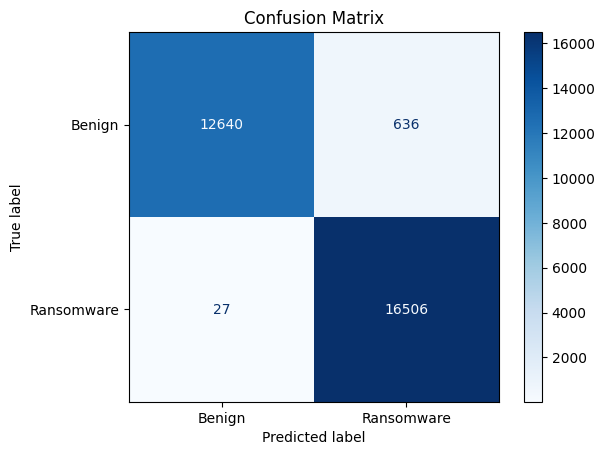

In [10]:
# 11. Visualize Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Ransomware'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# Sample Predictions

In [11]:
# 12. Inference on sample incoming traffic (from test set)
sample_indices = np.random.choice(len(X_test), size=5, replace=False)
sample_data = X_test[sample_indices]
sample_labels = y_test[sample_indices]
sample_inputs = torch.tensor(sample_data, dtype=torch.float32)
with torch.no_grad():
    sample_q = policy_net(sample_inputs)
sample_actions = sample_q.argmax(dim=1).numpy()
print("Sample Predictions (1=ransomware, 0=benign):", sample_actions)
print("Actual Labels:", sample_labels)

Sample Predictions (1=ransomware, 0=benign): [1 1 0 0 0]
Actual Labels: [1 1 0 0 0]




Note: In the next phase (Milestone 2), we plan to improve the model by simulating real Zero-Day attack detection. Instead of random splitting, the dataset will be split based on unseen ransomware families. This will test the model's ability to detect attacks from new, previously unseen types.



# Milestone2

Zero-Day Simulation Code

Training Families: ['WannaCry' 'JigSaw' 'APT' 'EDA2' 'SamSam' 'TowerWeb' 'DMALocker' 'Globe'
 'CryptoLocker' 'CryptoLocker2015' 'Razy']
Testing (Zero-Day) Families: ['NoobCrypt' 'Flyper' 'Locky' 'Globev3' 'CryptXXX' 'Cryptohitman']
Training samples: 97177, Testing (Zero-Day) samples: 51866
Training completed.
Zero-Day Test Accuracy: 0.954


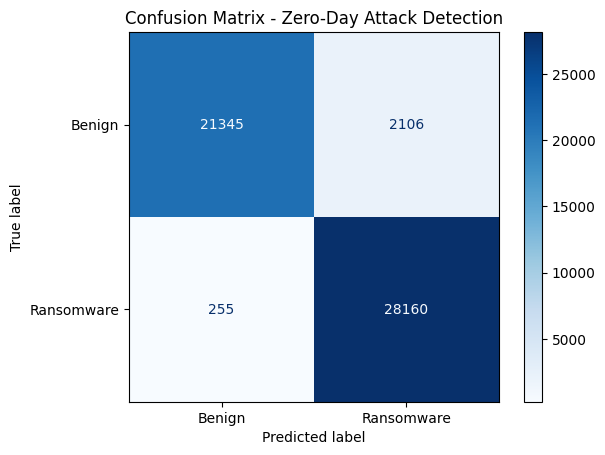

Trained model saved as 'dqn_ransomware_detector_zero_day.pt'


In [12]:
# 1. Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random


# 2. Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/ugransome-dataset/final(2).csv')
data.columns = ["Time", "Protocol", "Flag", "Family", "Clusters", "SeedAddress",
                "ExpAddress", "BTC", "USD", "Netflow_Bytes", "IPaddress",
                "Threats", "Port", "Prediction"]

# Drop missing values
if data.isnull().values.any():
    data = data.dropna()

# Map 'Prediction' to binary Label
data['Label'] = data['Prediction'].map({'S': 0, 'A': 1, 'SS': 1})

# Drop unnecessary columns
data = data.drop(columns=['Prediction', 'SeedAddress', 'ExpAddress', 'IPaddress'])

# 3. Zero-Day Family Split BEFORE Encoding
families = data['Family'].unique()
np.random.shuffle(families)

split_idx = int(0.7 * len(families))
train_families = families[:split_idx]
test_families = families[split_idx:]

train_mask = data['Family'].isin(train_families)
test_mask = data['Family'].isin(test_families)

train_data = data[train_mask].copy()
test_data = data[test_mask].copy()

print(f"Training Families: {train_families}")
print(f"Testing (Zero-Day) Families: {test_families}")

# Only encode Protocol, Flag, Threats (NOT Family!)
for col in ['Protocol', 'Flag', 'Threats']:
    label_encoder = LabelEncoder()
    train_data[col] = label_encoder.fit_transform(train_data[col].astype(str))
    test_data[col] = label_encoder.transform(test_data[col].astype(str))

# Then DROP Family column
train_data = train_data.drop(columns=['Family'])
test_data = test_data.drop(columns=['Family'])



# 5. Feature Scaling
scaler = MinMaxScaler()
feature_cols = [col for col in train_data.columns if col != 'Label']

train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data[feature_cols] = scaler.transform(test_data[feature_cols])

# 6. Prepare Train and Test Sets
X_train = train_data[feature_cols].values.astype(np.float32)
y_train = train_data['Label'].values.astype(np.int64)
X_test = test_data[feature_cols].values.astype(np.float32)
y_test = test_data['Label'].values.astype(np.int64)

print(f"Training samples: {len(X_train)}, Testing (Zero-Day) samples: {len(X_test)}")

# 7. Define the Environment
class RansomwareEnv:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n_samples = len(X)
        self.idx = 0
        self.order = None
        self.reset()
    def reset(self):
        self.order = np.random.permutation(self.n_samples)
        self.idx = 0
        return self.X[self.order[self.idx]]
    def step(self, action):
        current_index = self.order[self.idx]
        actual_label = self.y[current_index]
        if action == 1:
            reward = 1.0 if actual_label == 1 else -0.5
        else:
            reward = 0.1 if actual_label == 0 else -1.0
        self.idx += 1
        done = self.idx >= self.n_samples
        next_state = None if done else self.X[self.order[self.idx]]
        return next_state, reward, done

env = RansomwareEnv(X_train, y_train)

# 8. Define the DQN Model
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, x):
        return self.net(x)

state_dim = X_train.shape[1]
action_dim = 2
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# 9. Set Hyperparameters
learning_rate = 0.001
gamma = 0.99
batch_size = 64
max_episodes = 10
max_steps_per_episode = 20000
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
memory = []
mem_max_size = 100000

# 10. Training Loop
epsilon = epsilon_start
for episode in range(max_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    for t in range(max_steps_per_episode):
        if random.random() < epsilon:
            action = random.randrange(action_dim)
        else:
            with torch.no_grad():
                q_values = policy_net(state.unsqueeze(0))
                action = int(torch.argmax(q_values[0]).item())
        next_state, reward, done = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32) if next_state is not None else None
        memory.append((state, action, reward, next_state_tensor, done))
        if len(memory) > mem_max_size:
            memory.pop(0)
        state = next_state_tensor if next_state_tensor is not None else None

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            state_batch = torch.stack([b[0] for b in batch])
            action_batch = torch.tensor([b[1] for b in batch])
            reward_batch = torch.tensor([b[2] for b in batch], dtype=torch.float32)
            non_final_mask = torch.tensor([not b[4] for b in batch], dtype=torch.bool)
            non_final_next_states = torch.stack([b[3] for b in batch if b[3] is not None])

            q_values = policy_net(state_batch)
            state_action_values = q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)
            next_q_values = torch.zeros(batch_size, dtype=torch.float32)
            if non_final_next_states.size(0) > 0:
                with torch.no_grad():
                    max_next_q = target_net(non_final_next_states).max(dim=1)[0]
                next_q_values[non_final_mask] = max_next_q
            targets = reward_batch + gamma * next_q_values

            loss = loss_fn(state_action_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done or t == max_steps_per_episode - 1:
            target_net.load_state_dict(policy_net.state_dict())
            break

    if epsilon > epsilon_end:
        epsilon *= epsilon_decay

print("Training completed.")

# 11. Evaluation on Zero-Day Test Set
policy_net.eval()
test_inputs = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    test_q_values = policy_net(test_inputs)
test_predictions = test_q_values.argmax(dim=1).numpy()
accuracy = np.mean(test_predictions == y_test)
print(f"Zero-Day Test Accuracy: {accuracy:.3f}")

# 12. Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Ransomware'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Zero-Day Attack Detection')
plt.show()

# 13. Save the Model
torch.save(policy_net.state_dict(), 'dqn_ransomware_detector_zero_day.pt')
print("Trained model saved as 'dqn_ransomware_detector_zero_day.pt'")


Training Families: ['CryptXXX' 'Globe' 'APT' 'SamSam' 'JigSaw' 'Globev3' 'DMALocker'
 'Cryptohitman' 'CryptoLocker2015' 'WannaCry' 'Locky']
Testing (Zero-Day) Families: ['EDA2' 'Razy' 'CryptoLocker' 'NoobCrypt' 'TowerWeb' 'Flyper']
Training samples: 116696, Testing samples: 32347
Training completed.
Zero-Day Test Accuracy: 0.924


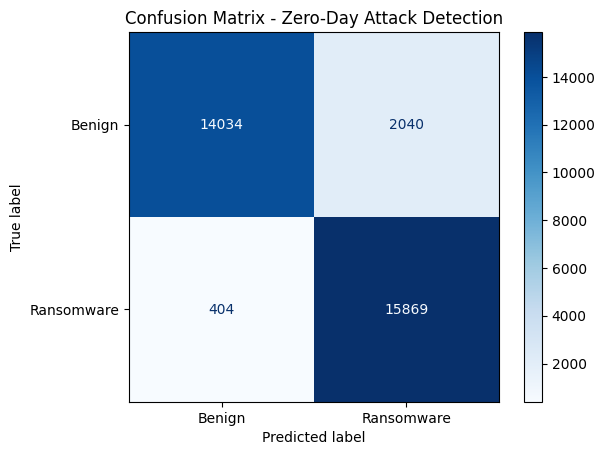

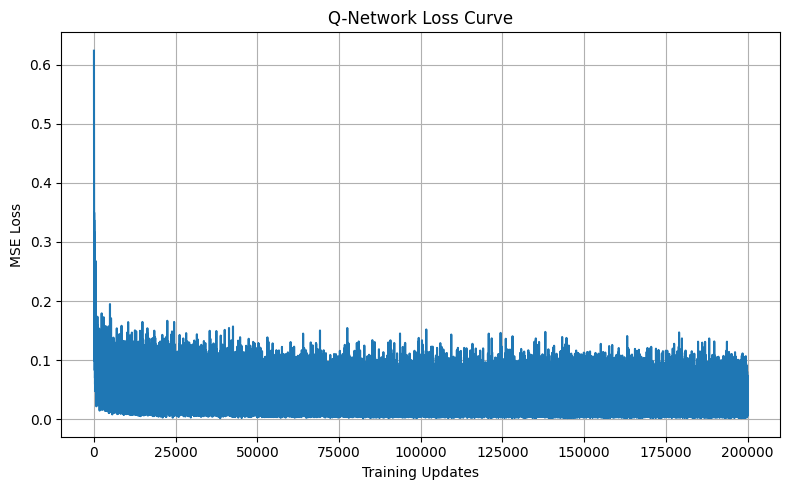

Model saved: dqn_ransomware_detector_zero_day.pt


In [1]:
# 1. Import Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random

# 2. Load and Preprocess the Dataset
data = pd.read_csv('/kaggle/input/ugransome-dataset/final(2).csv')
data.columns = [
    "Time", "Protocol", "Flag", "Family", "Clusters", "SeedAddress",
    "ExpAddress", "BTC", "USD", "Netflow_Bytes", "IPaddress",
    "Threats", "Port", "Prediction"
]

# Drop missing values
data = data.dropna()

# Map 'Prediction' to binary Label
data['Label'] = data['Prediction'].map({'S': 0, 'A': 1, 'SS': 1})

# Drop unnecessary columns
data = data.drop(columns=['Prediction', 'SeedAddress', 'ExpAddress', 'IPaddress'])

# 3. Zero-Day Family Split BEFORE Encoding
families = data['Family'].unique()
np.random.shuffle(families)
split_idx = int(0.7 * len(families))
train_families = families[:split_idx]
test_families = families[split_idx:]

train_mask = data['Family'].isin(train_families)
test_mask  = data['Family'].isin(test_families)

train_data = data[train_mask].copy()
test_data  = data[test_mask].copy()

print(f"Training Families: {train_families}")
print(f"Testing (Zero-Day) Families: {test_families}")

# 4. Encode Categorical Features (Protocol, Flag, Threats)
for col in ['Protocol', 'Flag', 'Threats']:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    test_data[col]  = le.transform(test_data[col].astype(str))

# Drop the 'Family' column
train_data = train_data.drop(columns=['Family'])
test_data  = test_data.drop(columns=['Family'])

# 5. Feature Scaling
scaler = MinMaxScaler()
feature_cols = [c for c in train_data.columns if c != 'Label']
train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data[feature_cols]  = scaler.transform(test_data[feature_cols])

# 6. Prepare Train and Test Sets
X_train = train_data[feature_cols].values.astype(np.float32)
y_train = train_data['Label'].values.astype(np.int64)
X_test  = test_data[feature_cols].values.astype(np.float32)
y_test  = test_data['Label'].values.astype(np.int64)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# 7. Define the Environment
class RansomwareEnv:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n_samples = len(X)
        self.idx = 0
    def reset(self):
        self.order = np.random.permutation(self.n_samples)
        self.idx = 0
        return self.X[self.order[self.idx]]
    def step(self, action):
        current = self.order[self.idx]
        actual  = self.y[current]
        reward = 1.0 if (action == 1 and actual == 1) else \
                 (0.1 if (action == 0 and actual == 0) else \
                 (-0.5 if action == 1 else -1.0))
        self.idx += 1
        done = self.idx >= self.n_samples
        next_state = None if done else self.X[self.order[self.idx]]
        return next_state, reward, done

env = RansomwareEnv(X_train, y_train)

# 8. Define the DQN Model
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, x):
        return self.net(x)

state_dim  = X_train.shape[1]
action_dim = 2
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# 9. Set Hyperparameters
learning_rate         = 0.001
gamma                 = 0.99
batch_size            = 64
max_episodes          = 10
max_steps_per_episode = 20000
epsilon_start         = 1.0
epsilon_end           = 0.1
epsilon_decay         = 0.995
mem_max_size          = 100000

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_fn    = nn.MSELoss()
memory     = []

# 10. Training Loop (with loss recording)
losses = []
epsilon = epsilon_start

for episode in range(max_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    for t in range(max_steps_per_episode):
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.randrange(action_dim)
        else:
            with torch.no_grad():
                q_vals = policy_net(state.unsqueeze(0))
                action = int(q_vals.argmax(dim=1)[0])

        # Step environment
        next_state, reward, done = env.step(action)
        next_tensor = torch.tensor(next_state, dtype=torch.float32) if next_state is not None else None

        # Store transition
        memory.append((state, action, reward, next_tensor, done))
        if len(memory) > mem_max_size:
            memory.pop(0)
        state = next_tensor

        # Optimize
        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states      = torch.stack([b[0] for b in batch])
            actions     = torch.tensor([b[1] for b in batch])
            rewards     = torch.tensor([b[2] for b in batch], dtype=torch.float32)
            mask        = torch.tensor([not b[4] for b in batch], dtype=torch.bool)
            next_states = torch.stack([b[3] for b in batch if b[3] is not None])

            q_values          = policy_net(states)
            state_action_vals = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

            next_q = torch.zeros(batch_size, dtype=torch.float32)
            if next_states.size(0) > 0:
                with torch.no_grad():
                    next_q_vals = target_net(next_states).max(dim=1)[0]
                next_q[mask] = next_q_vals

            targets = rewards + gamma * next_q
            loss    = loss_fn(state_action_vals, targets)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            target_net.load_state_dict(policy_net.state_dict())
            break

    epsilon = max(epsilon * epsilon_decay, epsilon_end)

print("Training completed.")

# 11. Evaluation on Zero-Day Test Set
policy_net.eval()
with torch.no_grad():
    test_in  = torch.tensor(X_test, dtype=torch.float32)
    test_q   = policy_net(test_in)
test_predictions = test_q.argmax(dim=1).numpy()
accuracy = (test_predictions == y_test).mean()
print(f"Zero-Day Test Accuracy: {accuracy:.3f}")

# 12. Confusion Matrix
cm   = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Ransomware'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Zero-Day Attack Detection')
plt.show()

# 13. Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.xlabel('Training Updates')
plt.ylabel('MSE Loss')
plt.title('Q-Network Loss Curve')
plt.grid(True)
plt.tight_layout()
plt.show()

# 14. Save the Model
torch.save(policy_net.state_dict(), 'dqn_ransomware_detector_zero_day.pt')
print("Model saved: dqn_ransomware_detector_zero_day.pt")


The loss plunges quickly from ~0.6 to around 0.1 and then plateaus, indicating your Q-network has largely converged. Occasional spikes are just “hard” transitions from the replay buffer and don’t affect overall stability.

# Experiment 1: Random Split

Experiment 1 (Random Split) Accuracy: 96.93%


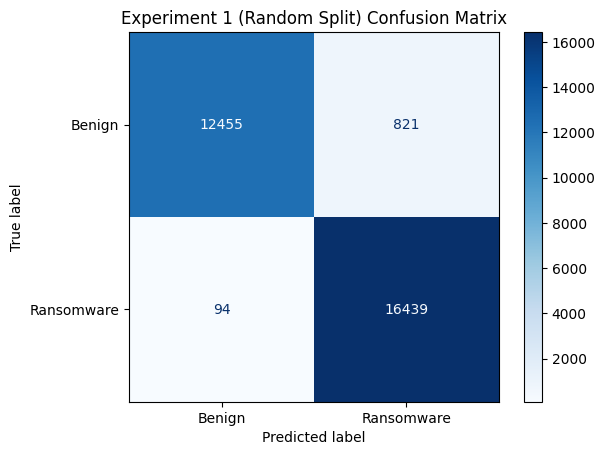

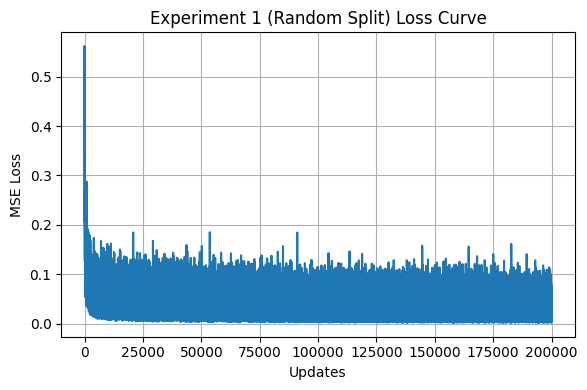

In [14]:
# Full script: Experiment 1 (Random Split) & Experiment 2 (Zero-Day Family Split)
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim

# ─── 1. Load & Clean ──────────────────────────────────────────────────────────────
data = pd.read_csv('/kaggle/input/ugransome-dataset/final(2).csv')
data.columns = ["Time","Protocol","Flag","Family","Clusters",
                "SeedAddress","ExpAddress","BTC","USD","Netflow_Bytes",
                "IPaddress","Threats","Port","Prediction"]
data = data.dropna()
data['Label'] = data['Prediction'].map({'S':0,'A':1,'SS':1})
data = data.drop(columns=['Prediction','SeedAddress','ExpAddress','IPaddress'])

# ─── 2. Environment & DQN Definitions ──────────────────────────────────────────────
class RansomwareEnv:
    def __init__(self, X, y):
        self.X, self.y = X, y
        self.n = len(X)
    def reset(self):
        self.order = np.random.permutation(self.n)
        self.i = 0
        return self.X[self.order[self.i]]
    def step(self, action):
        idx = self.order[self.i]
        actual = self.y[idx]
        # reward scheme
        if action==1:
            reward = 1.0 if actual==1 else -0.5
        else:
            reward = 0.1 if actual==0 else -1.0
        self.i += 1
        done = self.i >= self.n
        nxt = None if done else self.X[self.order[self.i]]
        return nxt, reward, done

class DQN(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim,64), nn.ReLU(),
            nn.Linear(64,64),    nn.ReLU(),
            nn.Linear(64,a_dim)
        )
    def forward(self,x):
        return self.net(x)

def run_experiment(name, X_train, y_train, X_test, y_test,
                   episodes=10, steps=20000, batch_size=64):
    # encode & scale (already numeric here), then train
    env    = RansomwareEnv(X_train, y_train)
    policy = DQN(X_train.shape[1], 2)
    target = DQN(X_train.shape[1], 2)
    target.load_state_dict(policy.state_dict()); target.eval()

    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    loss_fn   = nn.MSELoss()
    memory    = []
    losses    = []
    eps, eps_end, eps_decay = 1.0, 0.1, 0.995

    for ep in range(episodes):
        state = torch.tensor(env.reset(), dtype=torch.float32)
        for _ in range(steps):
            if random.random() < eps:
                action = random.randrange(2)
            else:
                with torch.no_grad():
                    action = int(policy(state.unsqueeze(0)).argmax(dim=1))

            nxt, reward, done = env.step(action)
            nxt_t = None if nxt is None else torch.tensor(nxt, dtype=torch.float32)
            memory.append((state, action, reward, nxt_t, done))
            if len(memory)>100_000: memory.pop(0)
            state = nxt_t

            if len(memory)>=batch_size:
                batch = random.sample(memory, batch_size)
                s_batch = torch.stack([b[0] for b in batch])
                a_batch = torch.tensor([b[1] for b in batch])
                r_batch = torch.tensor([b[2] for b in batch],dtype=torch.float32)
                mask    = torch.tensor([not b[4] for b in batch],dtype=torch.bool)
                next_s  = torch.stack([b[3] for b in batch if b[3] is not None])

                q_vals = policy(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)
                next_q = torch.zeros(batch_size)
                if next_s.size(0)>0:
                    with torch.no_grad():
                        next_q_vals = target(next_s).max(dim=1)[0]
                    next_q[mask] = next_q_vals
                targets = r_batch + 0.99*next_q

                loss = loss_fn(q_vals, targets)
                losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                target.load_state_dict(policy.state_dict())
                break

        eps = max(eps*eps_decay, eps_end)

    # Evaluation
    policy.eval()
    with torch.no_grad():
        inp  = torch.tensor(X_test, dtype=torch.float32)
        out  = policy(inp).argmax(dim=1).numpy()
    acc = (out==y_test).mean()
    print(f"{name} Accuracy: {acc*100:.2f}%")

    # Confusion Matrix
    cm   = confusion_matrix(y_test, out)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Benign','Ransomware'])
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix'); plt.show()

    # Loss Curve
    plt.figure(figsize=(6,4))
    plt.plot(losses)
    plt.title(f'{name} Loss Curve')
    plt.xlabel('Updates'); plt.ylabel('MSE Loss'); plt.grid(True)
    plt.tight_layout(); plt.show()


# ─── 3. Experiment 1: Random Split ────────────────────────────────────────────────
# split rows 80/20
df1 = data.copy()
for col in ['Protocol','Flag','Threats']:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col].astype(str))
X = df1.drop(columns=['Family','Label']).pipe(MinMaxScaler().fit_transform)
y = df1['Label'].values
Xtr1, Xte1, ytr1, yte1 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
run_experiment("Experiment 1 (Random Split)", Xtr1, ytr1, Xte1, yte1)





# Experiment 2: Zero-Day Family Split 

Experiment 2 (Zero-Day Split) Accuracy: 95.62%


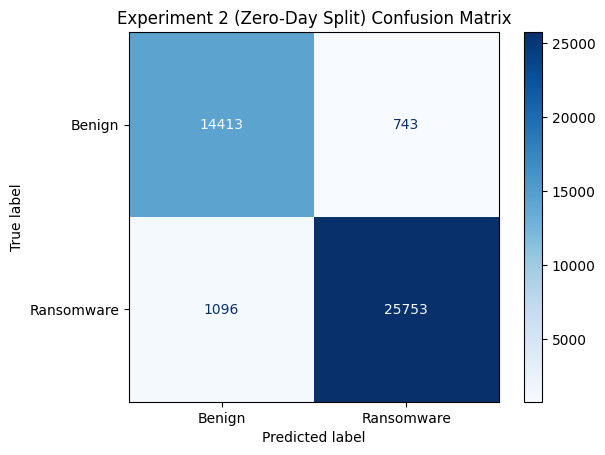

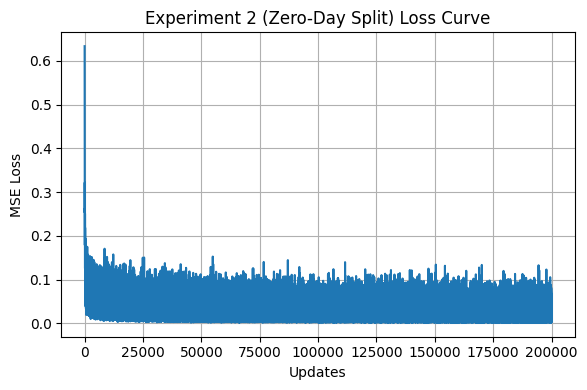

In [15]:
# Experiment 2: Zero-Day Family Split Simulation

# 1. Split by Family
families = data['Family'].unique()
np.random.shuffle(families)
cut = int(0.7 * len(families))
train_fam, test_fam = families[:cut], families[cut:]

train_df = data[data['Family'].isin(train_fam)].copy()
test_df  = data[data['Family'].isin(test_fam)].copy()

# 2. Encode categorical features
for col in ['Protocol', 'Flag', 'Threats']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))

# 3. Drop the Family column
train_df = train_df.drop(columns=['Family'])
test_df  = test_df.drop(columns=['Family'])

# 4. Scale features (fit on train, transform both)
feature_cols = [c for c in train_df.columns if c != 'Label']
scaler = MinMaxScaler().fit(train_df[feature_cols])

X_train2 = scaler.transform(train_df[feature_cols]).astype(np.float32)
y_train2 = train_df['Label'].values.astype(np.int64)

X_test2  = scaler.transform(test_df[feature_cols]).astype(np.float32)
y_test2  = test_df['Label'].values.astype(np.int64)

# 5. Run the experiment (using the same DQN/train loop as before)
run_experiment(
    "Experiment 2 (Zero-Day Split)",
    X_train2, y_train2,
    X_test2,  y_test2
)


Experiment 3 Accuracy: 60.05%


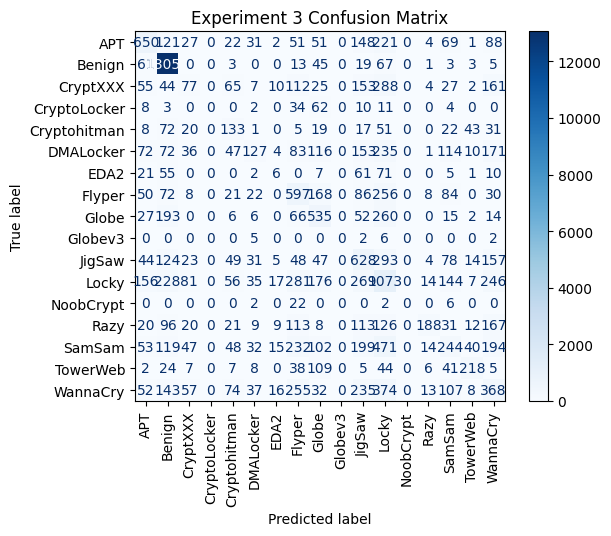

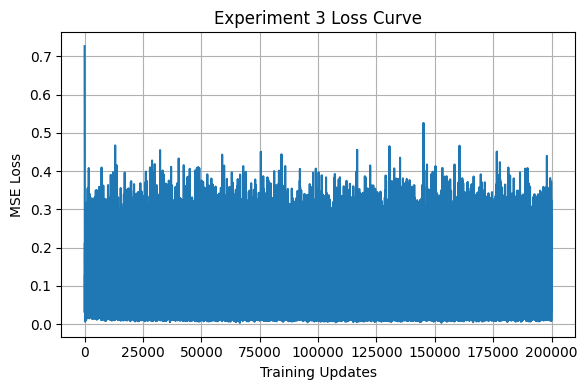

In [3]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ─── 1. Load & Preprocess ─────────────────────────────────────────────────────────
df = pd.read_csv('/kaggle/input/ugransome-dataset/final(2).csv')
df.columns = ["Time","Protocol","Flag","Family","Clusters",
              "SeedAddress","ExpAddress","BTC","USD",
              "Netflow_Bytes","IPaddress","Threats","Port","Prediction"]
df = df.dropna()

# multiclass label: each ransomware Family + Benign
df['MC_Label'] = df['Family']
df.loc[df['Prediction']=='S', 'MC_Label'] = 'Benign'
df.drop(columns=['Prediction','SeedAddress','ExpAddress','IPaddress','Family'], inplace=True)

# encode categorical features
for c in ['Protocol','Flag','Threats']:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

# features & labels
X_all = df.drop(columns=['MC_Label']).values.astype(np.float32)
le_lbl = LabelEncoder().fit(df['MC_Label'])
y_all = le_lbl.transform(df['MC_Label'])
class_names = list(le_lbl.classes_)

# scale features
X_all = MinMaxScaler().fit_transform(X_all)

# ─── 2. Environment & DQN ──────────────────────────────────────────────────────────
class MultiClassEnv:
    def __init__(self, X, y):
        self.X, self.y = X, y; self.n = len(X)
    def reset(self):
        self.order = np.random.permutation(self.n); self.i = 0
        return self.X[self.order[self.i]]
    def step(self, a):
        idx = self.order[self.i]
        reward = 1.0 if a == self.y[idx] else -1.0
        self.i += 1
        done = self.i >= self.n
        next_state = None if done else self.X[self.order[self.i]]
        return next_state, reward, done

class DQN(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim,64), nn.ReLU(),
            nn.Linear(64,64),    nn.ReLU(),
            nn.Linear(64,a_dim)
        )
    def forward(self,x): return self.net(x)

# ─── 3. Hyperparameters ───────────────────────────────────────────────────────────
lr = 1e-3; gamma = 0.99
batch_size = 64; mem_max_size=100000
max_episodes=10; max_steps=20000
eps_start=1.0; eps_end=0.1; eps_decay=0.995
device = torch.device('cpu')

# ─── 4. Experiment 3: Multiclass Random Split ────────────────────────────────────
X3_tr, X3_te, y3_tr, y3_te = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

env3 = MultiClassEnv(X3_tr, y3_tr)
policy3 = DQN(X_all.shape[1], len(class_names)).to(device)
target3 = DQN(X_all.shape[1], len(class_names)).to(device)
target3.load_state_dict(policy3.state_dict()); target3.eval()

opt3 = optim.Adam(policy3.parameters(), lr=lr)
loss_fn = nn.MSELoss()
memory3, losses3 = [], []
eps = eps_start

for ep in range(max_episodes):
    state = torch.tensor(env3.reset(), dtype=torch.float32, device=device)
    for _ in range(max_steps):
        if random.random() < eps:
            action = random.randrange(len(class_names))
        else:
            with torch.no_grad():
                action = int(policy3(state.unsqueeze(0)).argmax(dim=1))
        nxt, r, done = env3.step(action)
        nxt_t = None if nxt is None else torch.tensor(nxt, dtype=torch.float32, device=device)
        memory3.append((state, action, r, nxt_t, done))
        if len(memory3) > mem_max_size: memory3.pop(0)
        state = nxt_t
        if len(memory3) >= batch_size:
            batch = random.sample(memory3, batch_size)
            states = torch.stack([b[0] for b in batch])
            actions = torch.tensor([b[1] for b in batch], device=device)
            rewards = torch.tensor([b[2] for b in batch], dtype=torch.float32, device=device)
            mask = torch.tensor([not b[4] for b in batch], device=device)
            next_s = torch.stack([b[3] for b in batch if b[3] is not None])
            qv = policy3(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q = torch.zeros(batch_size, device=device)
            if next_s.size(0)>0:
                with torch.no_grad():
                    max_nq = target3(next_s).max(dim=1)[0]
                next_q[mask] = max_nq
            targets = rewards + gamma * next_q
            loss = loss_fn(qv, targets)
            losses3.append(loss.item())
            opt3.zero_grad(); loss.backward(); opt3.step()
        if done:
            target3.load_state_dict(policy3.state_dict()); break
    eps = max(eps * eps_decay, eps_end)

# Evaluate Experiment 3
policy3.eval()
with torch.no_grad():
    q3 = policy3(torch.tensor(X3_te, dtype=torch.float32, device=device))
pred3 = q3.argmax(dim=1).cpu().numpy()
acc3 = accuracy_score(y3_te, pred3)
print(f"Experiment 3 Accuracy: {acc3*100:.2f}%")

lbls3 = np.unique(np.concatenate([y3_te, pred3]))
names3 = [class_names[i] for i in lbls3]
cm3 = confusion_matrix(y3_te, pred3, labels=lbls3)
disp3 = ConfusionMatrixDisplay(cm3, display_labels=names3)
disp3.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Experiment 3 Confusion Matrix')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(losses3)
plt.title('Experiment 3 Loss Curve')
plt.xlabel('Training Updates')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.tight_layout()
plt.show()




Experiment 4 (Mixed Test) Open-Set Accuracy: 90.91%
              precision    recall  f1-score   support

         APT       0.00      0.00      0.00       134
      Benign       0.00      0.00      0.00      1225
    CryptXXX       0.00      0.00      0.00        87
CryptoLocker       0.00      0.00      0.00        11
      Flyper       0.00      0.00      0.00       123
       Globe       0.00      0.00      0.00       116
      JigSaw       0.00      0.00      0.00       145
       Locky       0.00      0.00      0.00       288
   NoobCrypt       0.00      0.00      0.00         1
    TowerWeb       0.00      0.00      0.00        44
    WannaCry       0.00      0.00      0.00       148
     Unknown       0.91      1.00      0.95     23225

    accuracy                           0.91     25547
   macro avg       0.08      0.08      0.08     25547
weighted avg       0.83      0.91      0.87     25547



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


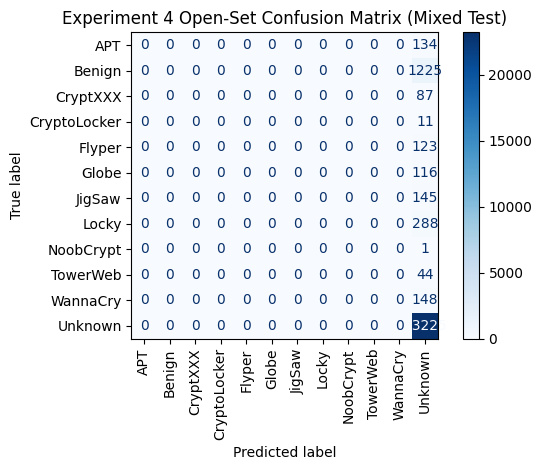

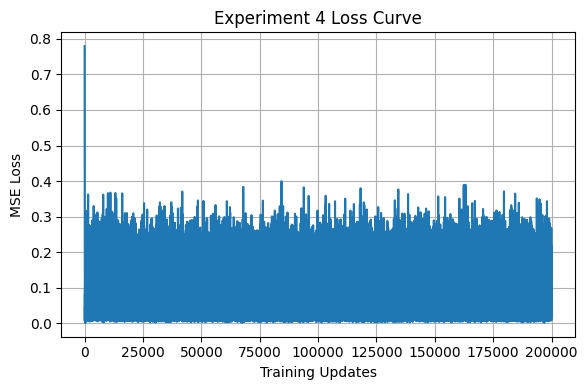

In [2]:
# Experiment 4: Multiclass Zero-Day Open-Set with Mixed Test Set (10% Known, 90% Unseen)

import numpy as np
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# 1) Split families into known/train and unseen/test
fams = [f for f in class_names if f != 'Benign']
random.shuffle(fams)
cut = int(0.7 * len(fams))
train_fams = set(fams[:cut] + ['Benign'])
# mask arrays
mask_known  = df['MC_Label'].isin(train_fams).values
mask_unseen = ~mask_known

idx_known  = np.where(mask_known)[0]
idx_unseen = np.where(mask_unseen)[0]

# 2) Build mixed test set: 10% of unseen count drawn from known
n_known_test  = int(0.1 * len(idx_unseen))
known_test_idx = np.random.choice(idx_known,  n_known_test, replace=False)
unseen_test_idx= idx_unseen
test_idx      = np.concatenate([known_test_idx, unseen_test_idx])

# 3) Remaining known samples form the train set
train_idx = np.setdiff1d(idx_known, known_test_idx)

X4_tr, y4_tr = X_all[train_idx], y_all[train_idx]
X4_te, y4_te = X_all[test_idx],  y_all[test_idx]

# 4) Initialize environment & networks
env4    = MultiClassEnv(X4_tr, y4_tr)
policy4 = DQN(X_all.shape[1], len(class_names)).to(device)
target4 = DQN(X_all.shape[1], len(class_names)).to(device)
target4.load_state_dict(policy4.state_dict())
target4.eval()

optimizer4 = optim.Adam(policy4.parameters(), lr=lr)
memory4, losses4 = [], []
epsilon = eps_start

# 5) DQN Training (known classes only)
for ep in range(max_episodes):
    state = torch.tensor(env4.reset(), dtype=torch.float32, device=device)
    for _ in range(max_steps):
        if random.random() < epsilon:
            action = random.randrange(len(class_names))
        else:
            with torch.no_grad():
                action = policy4(state.unsqueeze(0)).argmax(dim=1).item()
        nxt, reward, done = env4.step(action)
        nxt_t = None if nxt is None else torch.tensor(nxt, dtype=torch.float32, device=device)
        memory4.append((state, action, reward, nxt_t, done))
        if len(memory4) > mem_max_size: memory4.pop(0)
        state = nxt_t

        if len(memory4) >= batch_size:
            batch = random.sample(memory4, batch_size)
            states  = torch.stack([b[0] for b in batch])
            actions = torch.tensor([b[1] for b in batch], device=device)
            rewards = torch.tensor([b[2] for b in batch], dtype=torch.float32, device=device)
            mask    = torch.tensor([not b[4] for b in batch], device=device)
            next_s  = torch.stack([b[3] for b in batch if b[3] is not None])
            q_vals  = policy4(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            next_q = torch.zeros(batch_size, device=device)
            if next_s.size(0) > 0:
                with torch.no_grad():
                    next_q_vals = target4(next_s).max(dim=1)[0]
                next_q[mask] = next_q_vals

            targets = rewards + gamma * next_q
            loss = loss_fn(q_vals, targets)
            losses4.append(loss.item())
            optimizer4.zero_grad()
            loss.backward()
            optimizer4.step()

        if done:
            target4.load_state_dict(policy4.state_dict())
            break

    epsilon = max(epsilon * eps_decay, eps_end)

# 6) Open-set Inference & Evaluation
policy4.eval()
with torch.no_grad():
    q4 = policy4(torch.tensor(X4_te, dtype=torch.float32, device=device))
probs4   = torch.softmax(q4, dim=1).cpu().numpy()
max_p4   = probs4.max(axis=1)
base_pred= probs4.argmax(axis=1)

# threshold for "Unknown"
tau = 0.6
unknown_id = len(class_names)
pred_open4 = np.where(max_p4 < tau, unknown_id, base_pred)

# True open-set labels: map any y4_te ∉ train_fams → unknown_id
train_ids = {i for i,f in enumerate(class_names) if f in train_fams}
true_open4 = [y if y in train_ids else unknown_id for y in y4_te]

# Accuracy
acc4 = accuracy_score(true_open4, pred_open4)
print(f"Experiment 4 (Mixed Test) Open-Set Accuracy: {acc4*100:.2f}%")

# Classification report
lbls = np.unique(true_open4 + pred_open4.tolist())
names = [(class_names[i] if i < len(class_names) else 'Unknown') for i in lbls]
print(classification_report(true_open4, pred_open4, labels=lbls, target_names=names))

# Confusion matrix
cm4 = confusion_matrix(true_open4, pred_open4, labels=lbls)
disp4 = ConfusionMatrixDisplay(cm4, display_labels=names)
disp4.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Experiment 4 Open-Set Confusion Matrix (Mixed Test)')
plt.tight_layout(); plt.show()

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(losses4)
plt.title('Experiment 4 Loss Curve')
plt.xlabel('Training Updates')
plt.ylabel('MSE Loss')
plt.grid(True); plt.tight_layout(); plt.show()
